PyTorch: 2.6.0+cu124
Device: cuda
Clases: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Train: 15836 imágenes
Val:   6783 imágenes
Test:  7067 imágenes


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]



Epoch 1/50
Train Loss: 1.7115 | Train Acc: 0.3443
Val Loss:   1.3649 | Val Acc:   0.5197
LR: 0.000049
✔ Modelo mejorado guardado!

Epoch 2/50
Train Loss: 1.4860 | Train Acc: 0.4752
Val Loss:   1.2316 | Val Acc:   0.5924
LR: 0.000045
✔ Modelo mejorado guardado!

Epoch 3/50
Train Loss: 1.3883 | Train Acc: 0.5273
Val Loss:   1.1910 | Val Acc:   0.6096
LR: 0.000040
✔ Modelo mejorado guardado!

Epoch 4/50
Train Loss: 1.3481 | Train Acc: 0.5538
Val Loss:   1.1533 | Val Acc:   0.6298
LR: 0.000033
✔ Modelo mejorado guardado!

Epoch 5/50
Train Loss: 1.3048 | Train Acc: 0.5783
Val Loss:   1.1306 | Val Acc:   0.6456
LR: 0.000026
✔ Modelo mejorado guardado!

Epoch 6/50
Train Loss: 1.2883 | Train Acc: 0.5907
Val Loss:   1.1192 | Val Acc:   0.6593
LR: 0.000018
✔ Modelo mejorado guardado!

Epoch 7/50
Train Loss: 1.2412 | Train Acc: 0.6146
Val Loss:   1.1062 | Val Acc:   0.6649
LR: 0.000011
✔ Modelo mejorado guardado!

Epoch 8/50
Train Loss: 1.2253 | Train Acc: 0.6253
Val Loss:   1.0975 | Val Acc:   

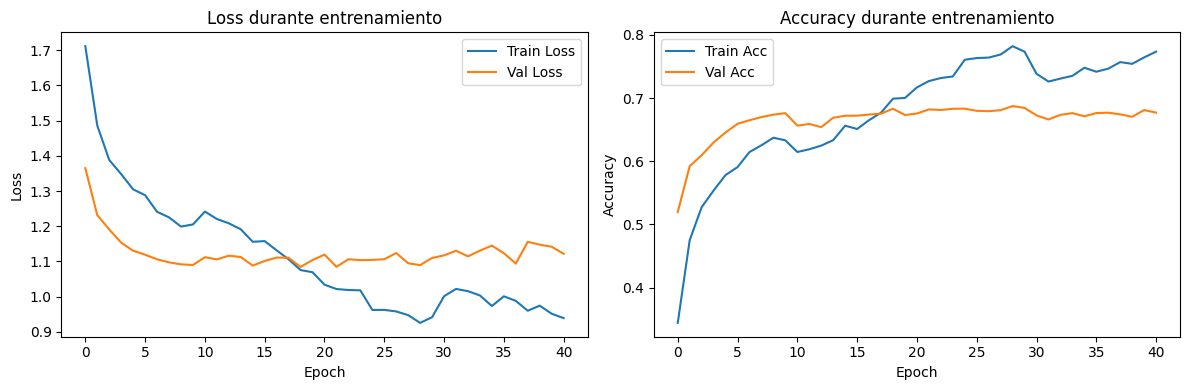


   RESULTADOS EN TEST
Test Loss: 1.0943
Test Acc:  0.6883
Best Val Acc: 0.6873


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

print("PyTorch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# =========================================================
# CONFIG
# =========================================================
DATASET_PATH = "/kaggle/input/emotions-dataset/dataset-imagenes-emociones"

train_dir = os.path.join(DATASET_PATH, "train")
val_dir   = os.path.join(DATASET_PATH, "val")
test_dir  = os.path.join(DATASET_PATH, "test")

IMG_SIZE = 224
BATCH_SIZE = 32  # Reducido para mejor generalización
EPOCHS = 50
LR = 5e-5  # Learning rate aún más bajo
WEIGHT_DECAY = 5e-4  # Más regularización

# =========================================================
# TRANSFORMS - AUGMENTATION MUY AGRESIVO
# =========================================================
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # Augmentation más agresivo
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.RandomGrayscale(p=0.1),  # Nuevo
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.15))
])

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# =========================================================
# DATASETS
# =========================================================
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_dataset.classes
print("Clases:", class_names)
print(f"Train: {len(train_dataset)} imágenes")
print(f"Val:   {len(val_dataset)} imágenes")
print(f"Test:  {len(test_dataset)} imágenes")

# =========================================================
# ESTRATEGIA 1: MODELO MÁS GRANDE (ResNet50) + MIXUP
# =========================================================
class MixUpAugmentation:
    def __init__(self, alpha=0.2):
        self.alpha = alpha
    
    def __call__(self, images, labels):
        if self.alpha > 0:
            lam = torch.distributions.Beta(self.alpha, self.alpha).sample()
            batch_size = images.size(0)
            index = torch.randperm(batch_size).to(images.device)
            
            mixed_images = lam * images + (1 - lam) * images[index]
            labels_a, labels_b = labels, labels[index]
            return mixed_images, labels_a, labels_b, lam
        return images, labels, labels, 1.0

mixup = MixUpAugmentation(alpha=0.2)

# Usar ResNet50 (más capacidad)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Congelar solo las primeras 2 capas
for name, param in model.named_parameters():
    if 'layer1' in name or 'layer2' in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

# Head con más regularización
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.4),
    nn.Linear(512, len(class_names))
)

model = model.to(device)

# =========================================================
# ESTRATEGIA 2: LABEL SMOOTHING + SAM OPTIMIZER
# =========================================================
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
    
    def forward(self, pred, target):
        n_class = pred.size(1)
        one_hot = torch.zeros_like(pred).scatter(1, target.view(-1, 1), 1)
        one_hot = one_hot * (1 - self.smoothing) + self.smoothing / n_class
        log_prob = torch.nn.functional.log_softmax(pred, dim=1)
        loss = -(one_hot * log_prob).sum(dim=1).mean()
        return loss

criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999)
)

# Cosine Annealing con Warm Restarts
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)

# =========================================================
# TRAINING LOOP CON MIXUP
# =========================================================
def train_one_epoch(model, loader, optimizer, criterion, mixup):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        # Aplicar MixUp
        mixed_images, labels_a, labels_b, lam = mixup(images, labels)
        
        optimizer.zero_grad()
        outputs = model(mixed_images)
        
        # MixUp loss
        loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (lam * (preds == labels_a).float() + (1 - lam) * (preds == labels_b).float()).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss, correct = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    return running_loss / len(loader.dataset), correct / len(loader.dataset)

# =========================================================
# TRAINING CON EARLY STOPPING MÁS AGRESIVO
# =========================================================
best_val_acc = 0
patience = 12  # Más paciencia
patience_counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, mixup)
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    scheduler.step()  # Actualizar learning rate
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"\nEpoch {epoch}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("✔ Modelo mejorado guardado!")
    else:
        patience_counter += 1
        print(f"⚠️ Sin mejora ({patience_counter}/{patience})")
        if patience_counter >= patience:
            print(f"🛑 Early stopping en epoch {epoch}")
            break

# =========================================================
# GRAFICAR CURVAS
# =========================================================
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss durante entrenamiento')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy durante entrenamiento')

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# =========================================================
# TEST EVALUATION
# =========================================================
model.load_state_dict(torch.load("best_model.pth"))
test_loss, test_acc = validate(model, test_loader, criterion)

print("\n============================")
print("   RESULTADOS EN TEST")
print("============================")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc:  {test_acc:.4f}")
print(f"Best Val Acc: {best_val_acc:.4f}")